In [1]:
import pyodbc
import pandas as pd

# Set your credentials here
server = 'DESKTOP-MFO02KK'  # or your instance name
database = 'DW_Finance'  # or the actual DB name
username = 'nesrine'  # if using SQL Server Authentication
password = 'nesrine'

# Use this if you're using SQL Server Authentication
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password}'
)

conn = pyodbc.connect(conn_str)

In [3]:
pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 1.1 MB/s eta 0:00:09
   --- ------------------------------------ 0.8/9.8 MB 1.1 MB/s eta 0:00:09
   ---- ----------------------------------- 1.0/9.8 MB 1.1 MB/s eta 0:00:08
   ----- ---------------------------------- 1.3/9.8 MB 1.1 MB/s eta 0:00:08
   ------ --------------------------------- 1.6/9.8 MB 1.1 MB/s eta 0:00:08
   ------ --------------------------------- 1.6/9.8 MB 1.1 MB/s eta 0:00:08
   ------- -------------------------------- 1.8/9.8 MB 1.1 MB/s eta 0:00:08
   -------- ------------------------------- 2.1/9.8 MB 1.1 MB/s eta 0:00:08
   --------- ------------------------------ 2.4/9.8 MB 1.1 MB/s eta 0:00:07
   ---------- -----------------


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\bouss\AppData\Local\Temp\ipykernel_7240\3915849584.py:44: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\bouss\AppData\Local\Temp\ipykernel_7240\3915849584.py:54: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df['AmountDue'].resample('M').sum()
C:\Users\bouss\AppData\Local\Temp\ipykernel_7240\3915849584.py:72: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled.fillna(method='ffill', inplace=True)
C:\Users\bouss\AppData\Local\Temp\ipykernel_7240\3915849584.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog.fillna(method='ffil

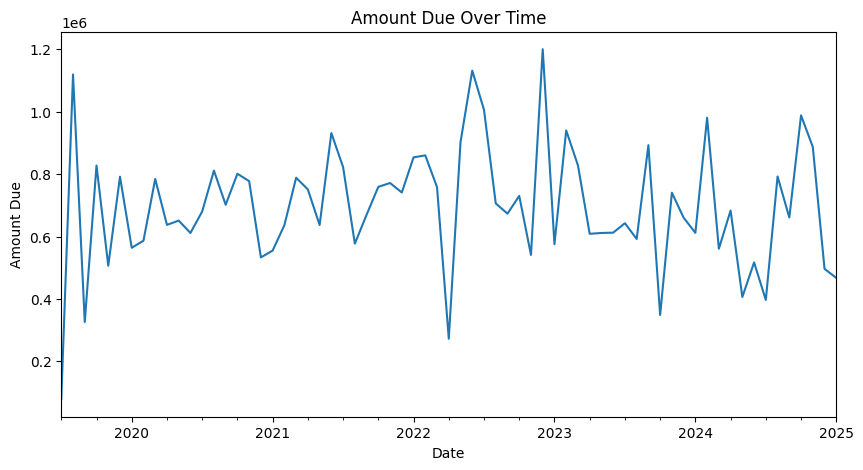

ADF Test for Stationarity on AmountDue:
ADF Statistic: -10.37022946140602
p-value: 2.27421215867602e-18
Series is stationary


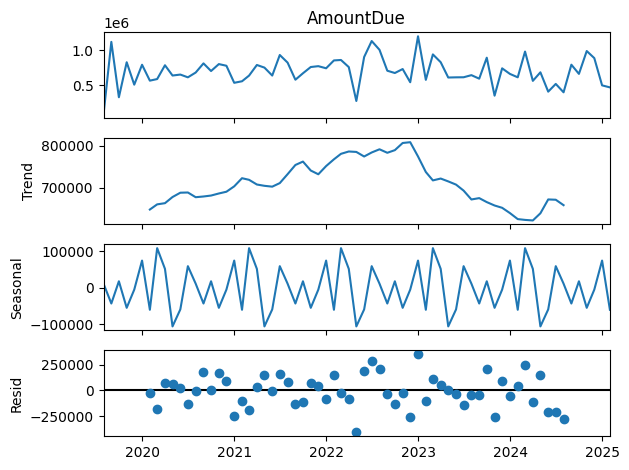

[ARIMA] MAE: 161446.82, MSE: 36728560333.23, RMSE: 191646.97


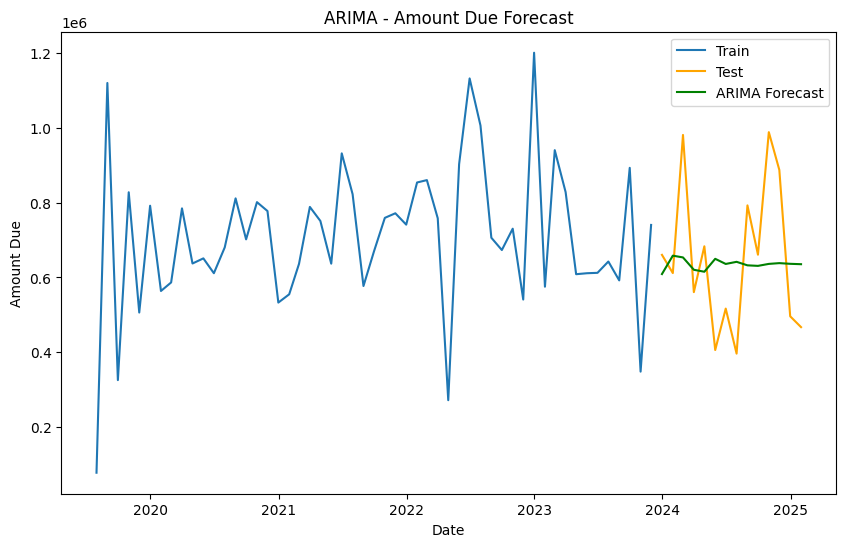

C:\Users\bouss\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[SARIMAX] MAE: 215761.84, MSE: 55539901407.62, RMSE: 235669.05


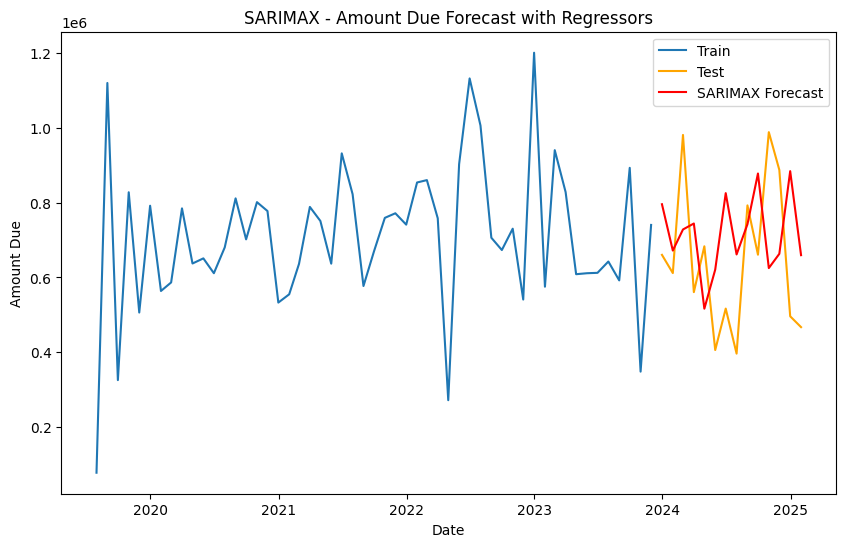

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
import pyodbc
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# SQL connection setup (if not already connected)
# conn = pyodbc.connect('DRIVER={SQL Server};SERVER=your_server;DATABASE=your_db;UID=your_uid;PWD=your_pwd')

# SQL query
query = """
SELECT 
    fs.AmountDue,
    fs.AmountPaid,
    fs.BalanceDue,
    fs.TotalAssets,
    fs.TotalLiabilities,
    fs.Equity,
    fs.ActualExpenses,
    fs.Budget,
    fs.Fk_Supplier,
    d.Status AS DisputeStatus,
    fs_date.Date AS FinancialDate,
    p.Amount AS PurchaseAmount,
    p_date.Date AS PurchaseDate
FROM 
    dbo.fact_Financial_Situation fs
JOIN 
    dbo.dim_disputes d ON fs.Fk_Disputes = d.Pk_Disputes
JOIN 
    dbo.Fact_Purchase p ON fs.Fk_Supplier = p.Fk_Supplier
JOIN 
    dbo.dim_date fs_date ON fs.Fk_Date = fs_date.Pk_Date
JOIN 
    dbo.dim_date p_date ON p.Fk_Date = p_date.Pk_Date
"""

# Load data
df = pd.read_sql(query, conn)

# Date formatting
df['FinancialDate'] = pd.to_datetime(df['FinancialDate'])
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

# Index setup
df.set_index('FinancialDate', inplace=True)

# Resample AmountDue monthly
df_resampled = df['AmountDue'].resample('M').sum()

# Resample PurchaseAmount monthly
purchase_monthly = df['PurchaseAmount'].groupby(df['PurchaseDate'].dt.to_period('M')).sum()
purchase_monthly.index = purchase_monthly.index.to_timestamp()
purchase_monthly = purchase_monthly.reindex(df_resampled.index, method='ffill')

# One-hot encode dispute status
df_encoded = pd.get_dummies(df[['DisputeStatus']], drop_first=True)
dispute_monthly = df_encoded.groupby(df.index.to_period('M')).mean()
dispute_monthly.index = dispute_monthly.index.to_timestamp()
dispute_monthly = dispute_monthly.reindex(df_resampled.index, method='ffill')

# Combine exogenous variables
exog = pd.concat([purchase_monthly, dispute_monthly], axis=1)
exog.columns = ['PurchaseAmount'] + list(dispute_monthly.columns)

# Fill missing values and replace inf values
df_resampled.fillna(method='ffill', inplace=True)
exog.replace([np.inf, -np.inf], np.nan, inplace=True)
exog.fillna(method='ffill', inplace=True)
exog.fillna(0, inplace=True)

# Visualize the time series
df_resampled.plot(title='Amount Due Over Time', figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Amount Due')
plt.show()

# **1. Stationarity Check - ADF Test**
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is non-stationary, differencing required")

# Perform ADF Test on the resampled series
print("ADF Test for Stationarity on AmountDue:")
adf_test(df_resampled)

# **2. If series is non-stationary, difference the series**
if adfuller(df_resampled)[1] > 0.05:  # If p-value > 0.05, series is non-stationary
    df_resampled_diff = df_resampled.diff().dropna()
    print("\nDifferenced Series (first difference):")
    adf_test(df_resampled_diff)
else:
    df_resampled_diff = df_resampled  # Already stationary

# **3. Check for Seasonality using Seasonal Decomposition**
decomposition = seasonal_decompose(df_resampled, model='additive', period=12)
decomposition.plot()
plt.show()

# Train-test split
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled[:train_size], df_resampled[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

# **4. Apply ARIMA if series is stationary**
model = ARIMA(train, order=(5, 1, 0))  # You might adjust the (p,d,q) parameters here
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# ARIMA Evaluation
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f'[ARIMA] MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}')

# Plot ARIMA Forecast
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='green')
plt.title('ARIMA - Amount Due Forecast')
plt.xlabel('Date')
plt.ylabel('Amount Due')
plt.legend()
plt.show()

# **5. Apply SARIMAX if seasonality is present**
sarimax_model = SARIMAX(train, exog=exog_train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))  # Add seasonal_order if seasonality detected
sarimax_fit = sarimax_model.fit()
sarimax_forecast = sarimax_fit.forecast(steps=len(test), exog=exog_test)

# SARIMAX Evaluation
sarimax_mae = mean_absolute_error(test, sarimax_forecast)
sarimax_mse = mean_squared_error(test, sarimax_forecast)
sarimax_rmse = np.sqrt(sarimax_mse)
print(f'[SARIMAX] MAE: {sarimax_mae:.2f}, MSE: {sarimax_mse:.2f}, RMSE: {sarimax_rmse:.2f}')

# Plot SARIMAX Forecast
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast', color='red')
plt.title('SARIMAX - Amount Due Forecast with Regressors')
plt.xlabel('Date')
plt.ylabel('Amount Due')
plt.legend()
plt.show()


C:\Users\bouss\AppData\Local\Temp\ipykernel_12048\2824181330.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\bouss\AppData\Local\Temp\ipykernel_12048\2824181330.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df['AmountDue'].resample('M').sum()
C:\Users\bouss\AppData\Local\Temp\ipykernel_12048\2824181330.py:73: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled.fillna(method='ffill', inplace=True)
C:\Users\bouss\AppData\Local\Temp\ipykernel_12048\2824181330.py:75: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog.fillna(method='

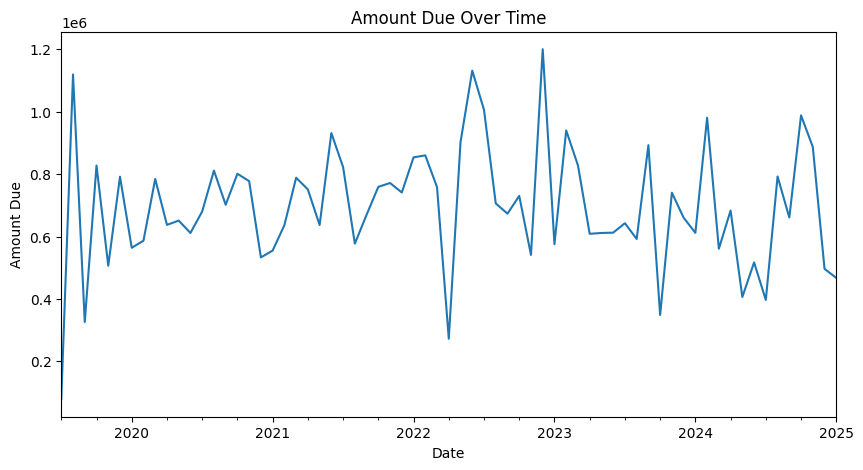

ADF Test for Stationarity on AmountDue:
ADF Statistic: -10.37022946140602
p-value: 2.27421215867602e-18
Series is stationary


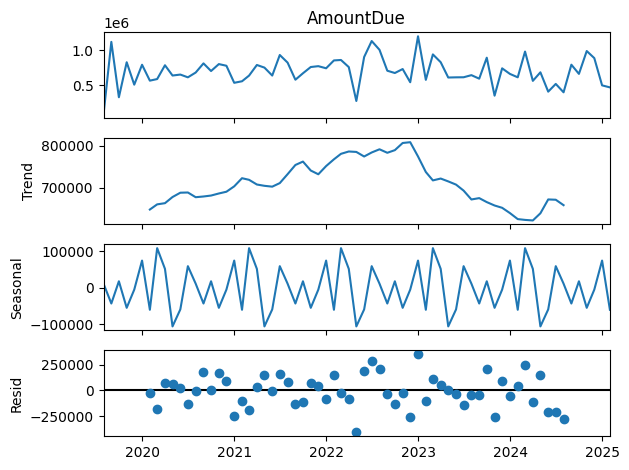

[ARIMA] MAE: 161446.82, MSE: 36728560333.23, RMSE: 191646.97


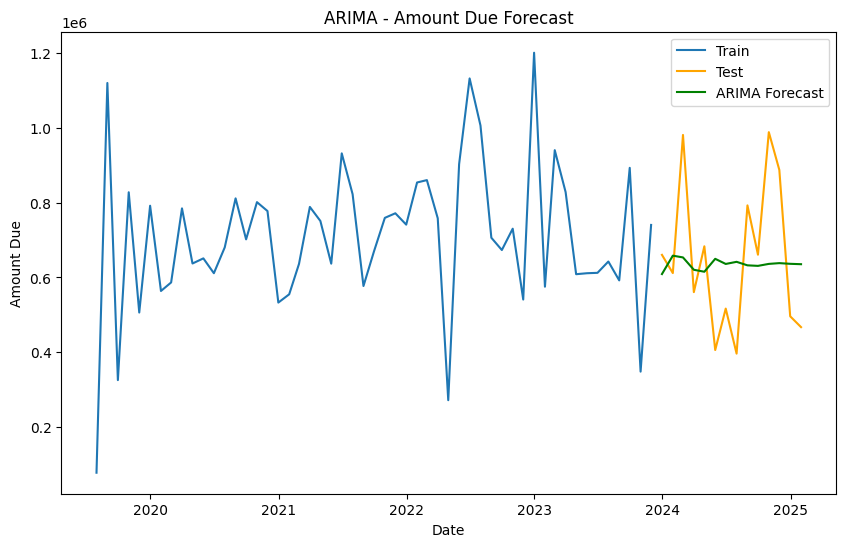

C:\Users\bouss\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[SARIMAX] MAE: 215761.84, MSE: 55539901407.62, RMSE: 235669.05


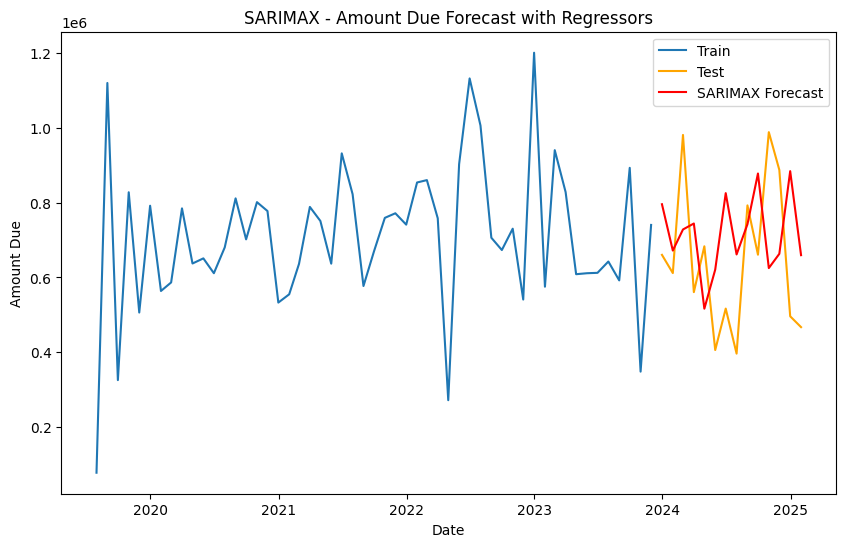

In [4]:
#updated code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
import pyodbc
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# SQL connection setup (if not already connected)
# conn = pyodbc.connect('DRIVER={SQL Server};SERVER=your_server;DATABASE=your_db;UID=your_uid;PWD=your_pwd')

# SQL query
query = """
SELECT 
    fs.AmountDue,
    fs.AmountPaid,
    fs.BalanceDue,
    fs.TotalAssets,
    fs.TotalLiabilities,
    fs.Equity,
    fs.ActualExpenses,
    fs.Budget,
    fs.Fk_Supplier,
    d.Status AS DisputeStatus,
    fs_date.Date AS FinancialDate,
    p.Amount AS PurchaseAmount,
    p_date.Date AS PurchaseDate
FROM 
    dbo.fact_Financial_Situation fs
JOIN 
    dbo.dim_disputes d ON fs.Fk_Disputes = d.Pk_Disputes
JOIN 
    dbo.Fact_Purchase p ON fs.Fk_Supplier = p.Fk_Supplier
JOIN 
    dbo.dim_date fs_date ON fs.Fk_Date = fs_date.Pk_Date
JOIN 
    dbo.dim_date p_date ON p.Fk_Date = p_date.Pk_Date
"""

# Load data
df = pd.read_sql(query, conn)

# Date formatting
df['FinancialDate'] = pd.to_datetime(df['FinancialDate'])
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

# Index setup
df.set_index('FinancialDate', inplace=True)

# Resample AmountDue monthly
df_resampled = df['AmountDue'].resample('M').sum()

# Resample PurchaseAmount monthly
purchase_monthly = df['PurchaseAmount'].groupby(df['PurchaseDate'].dt.to_period('M')).sum()
purchase_monthly.index = purchase_monthly.index.to_timestamp()
purchase_monthly = purchase_monthly.reindex(df_resampled.index, method='ffill')

# One-hot encode dispute status
df_encoded = pd.get_dummies(df[['DisputeStatus']], drop_first=True)
dispute_monthly = df_encoded.groupby(df.index.to_period('M')).mean()
dispute_monthly.index = dispute_monthly.index.to_timestamp()
dispute_monthly = dispute_monthly.reindex(df_resampled.index, method='ffill')

# Combine exogenous variables
exog = pd.concat([purchase_monthly, dispute_monthly], axis=1)
exog.columns = ['PurchaseAmount'] + list(dispute_monthly.columns)

# Fill missing values and replace inf values
df_resampled.fillna(method='ffill', inplace=True)
exog.replace([np.inf, -np.inf], np.nan, inplace=True)
exog.fillna(method='ffill', inplace=True)
exog.fillna(0, inplace=True)

# Visualize the time series
df_resampled.plot(title='Amount Due Over Time', figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Amount Due')
plt.show()

# **1. Stationarity Check - ADF Test**
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is non-stationary, differencing required")

# Perform ADF Test on the resampled series
print("ADF Test for Stationarity on AmountDue:")
adf_test(df_resampled)

# **2. If series is non-stationary, difference the series**
if adfuller(df_resampled)[1] > 0.05:  # If p-value > 0.05, series is non-stationary
    df_resampled_diff = df_resampled.diff().dropna()
    print("\nDifferenced Series (first difference):")
    adf_test(df_resampled_diff)
else:
    df_resampled_diff = df_resampled  # Already stationary

# **3. Check for Seasonality using Seasonal Decomposition**
decomposition = seasonal_decompose(df_resampled, model='additive', period=12)
decomposition.plot()
plt.show()

# Train-test split
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled[:train_size], df_resampled[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

# **4. Apply ARIMA if series is stationary**
model = ARIMA(train, order=(5, 1, 0))  # You might adjust the (p,d,q) parameters here
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# ARIMA Evaluation
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f'[ARIMA] MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}')

# Plot ARIMA Forecast
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='green')
plt.title('ARIMA - Amount Due Forecast')
plt.xlabel('Date')
plt.ylabel('Amount Due')
plt.legend()
plt.show()

# **5. Apply SARIMAX if seasonality is present**
sarimax_model = SARIMAX(train, exog=exog_train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))  # Add seasonal_order if seasonality detected
sarimax_fit = sarimax_model.fit()
sarimax_forecast = sarimax_fit.forecast(steps=len(test), exog=exog_test)

# SARIMAX Evaluation
sarimax_mae = mean_absolute_error(test, sarimax_forecast)
sarimax_mse = mean_squared_error(test, sarimax_forecast)
sarimax_rmse = np.sqrt(sarimax_mse)
print(f'[SARIMAX] MAE: {sarimax_mae:.2f}, MSE: {sarimax_mse:.2f}, RMSE: {sarimax_rmse:.2f}')

# Plot SARIMAX Forecast
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast', color='red')
plt.title('SARIMAX - Amount Due Forecast with Regressors')
plt.xlabel('Date')
plt.ylabel('Amount Due')
plt.legend()
plt.show()


C:\Users\bouss\AppData\Local\Temp\ipykernel_12048\3521339945.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\bouss\AppData\Local\Temp\ipykernel_12048\3521339945.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df['AmountDue'].resample('M').sum()
C:\Users\bouss\AppData\Local\Temp\ipykernel_12048\3521339945.py:70: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled.fillna(method='ffill', inplace=True)
C:\Users\bouss\AppData\Local\Temp\ipykernel_12048\3521339945.py:72: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog.fillna(method='

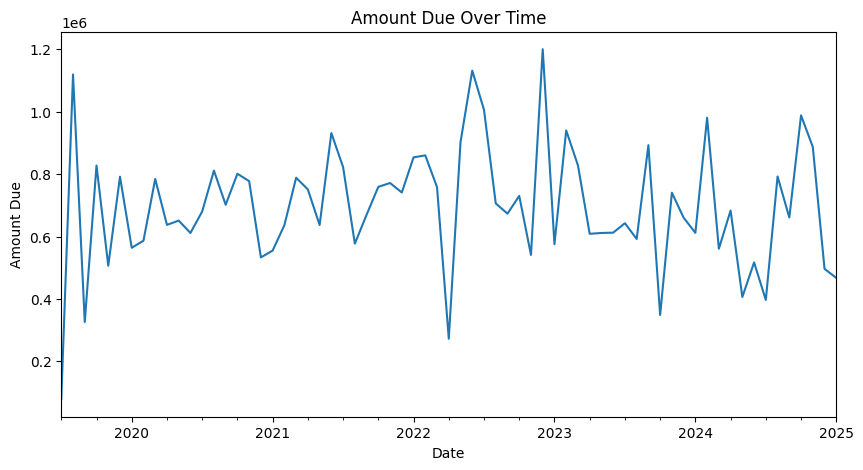

[ARIMA] MAE: 161446.82, MSE: 36728560333.23, RMSE: 191646.97


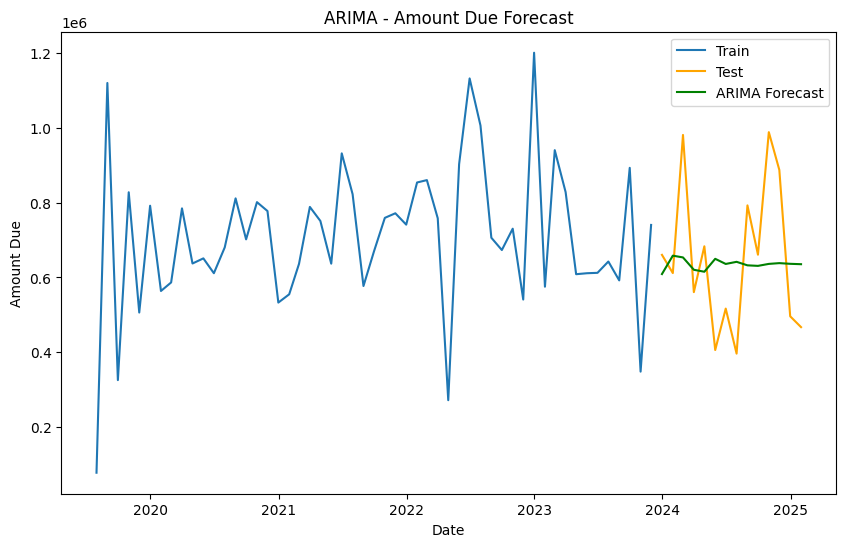

[SARIMAX] MAE: 159185.26, MSE: 36660659232.22, RMSE: 191469.73


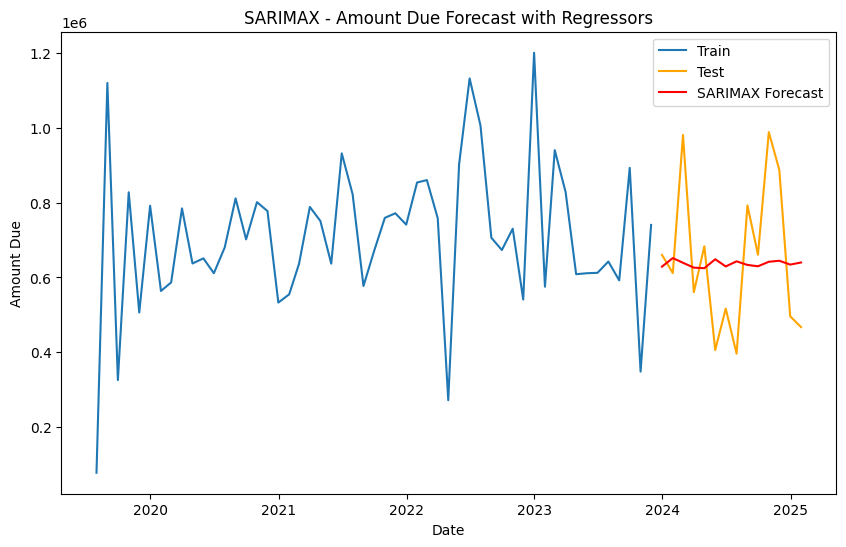

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
import pyodbc  # If you're using pyodbc for SQL Server connection

# SQL connection setup
# conn = pyodbc.connect('DRIVER={SQL Server};SERVER=your_server;DATABASE=your_db;UID=your_uid;PWD=your_pwd')

# SQL query
query = """
SELECT 
    fs.AmountDue,
    fs.AmountPaid,
    fs.BalanceDue,
    fs.TotalAssets,
    fs.TotalLiabilities,
    fs.Equity,
    fs.ActualExpenses,
    fs.Budget,
    fs.Fk_Supplier,
    d.Status AS DisputeStatus,
    fs_date.Date AS FinancialDate,
    p.Amount AS PurchaseAmount,
    p_date.Date AS PurchaseDate
FROM 
    dbo.fact_Financial_Situation fs
JOIN 
    dbo.dim_disputes d ON fs.Fk_Disputes = d.Pk_Disputes
JOIN 
    dbo.Fact_Purchase p ON fs.Fk_Supplier = p.Fk_Supplier
JOIN 
    dbo.dim_date fs_date ON fs.Fk_Date = fs_date.Pk_Date
JOIN 
    dbo.dim_date p_date ON p.Fk_Date = p_date.Pk_Date
"""

# Load data
df = pd.read_sql(query, conn)

# Date formatting
df['FinancialDate'] = pd.to_datetime(df['FinancialDate'])
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

# Index setup
df.set_index('FinancialDate', inplace=True)

# Resample AmountDue monthly
df_resampled = df['AmountDue'].resample('M').sum()

# Resample PurchaseAmount monthly
purchase_monthly = df['PurchaseAmount'].groupby(df['PurchaseDate'].dt.to_period('M')).sum()
purchase_monthly.index = purchase_monthly.index.to_timestamp()
purchase_monthly = purchase_monthly.reindex(df_resampled.index, method='ffill')

# One-hot encode dispute status
df_encoded = pd.get_dummies(df[['DisputeStatus']], drop_first=True)
dispute_monthly = df_encoded.groupby(df.index.to_period('M')).mean()
dispute_monthly.index = dispute_monthly.index.to_timestamp()
dispute_monthly = dispute_monthly.reindex(df_resampled.index, method='ffill')

# Combine exogenous variables
exog = pd.concat([purchase_monthly, dispute_monthly], axis=1)
exog.columns = ['PurchaseAmount'] + list(dispute_monthly.columns)

# Fill missing values and replace inf values
df_resampled.fillna(method='ffill', inplace=True)
exog.replace([np.inf, -np.inf], np.nan, inplace=True)
exog.fillna(method='ffill', inplace=True)
exog.fillna(0, inplace=True)

# Visualize
df_resampled.plot(title='Amount Due Over Time', figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Amount Due')
plt.show()

# Train-test split
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled[:train_size], df_resampled[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

# ARIMA Model
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# ARIMA Evaluation
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f'[ARIMA] MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}')

# Plot ARIMA
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='green')
plt.title('ARIMA - Amount Due Forecast')
plt.xlabel('Date')
plt.ylabel('Amount Due')
plt.legend()
plt.show()

# SARIMAX Model with cleaned exogenous regressors
sarimax_model = SARIMAX(train, exog=exog_train, order=(5, 1, 0))
sarimax_fit = sarimax_model.fit()
sarimax_forecast = sarimax_fit.forecast(steps=len(test), exog=exog_test)

# SARIMAX Evaluation
sarimax_mae = mean_absolute_error(test, sarimax_forecast)
sarimax_mse = mean_squared_error(test, sarimax_forecast)
sarimax_rmse = np.sqrt(sarimax_mse)
print(f'[SARIMAX] MAE: {sarimax_mae:.2f}, MSE: {sarimax_mse:.2f}, RMSE: {sarimax_rmse:.2f}')

# Plot SARIMAX
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast', color='red')
plt.title('SARIMAX - Amount Due Forecast with Regressors')
plt.xlabel('Date')
plt.ylabel('Amount Due')
plt.legend()
plt.show()
